In [1]:
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.ensemble
import sklearn.datasets
import sklearn.dummy
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from ridgereliability import metrics
import logging
import os
import multiprocessing
from tqdm import trange
import pickle

In [2]:
# example
logging.basicConfig(level=logging.INFO)

In [3]:
np.random.seed(42)

# Artificial data experiment

In this notebook we define an experiment for comparing the ECE and the PEACE error metrics. We train several classifiers on different randomly genereated artificial datasets. We control the properties of the artificial dataset by setting parameters of the dataset generation algorithm. We compare metrics over several dataset configurations, and each configuration is repeated multiple times for each classifier.

If you want to export this notebook to a script, use:

In [17]:
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# example']" --TemplateExporter.exclude_markdown=True --to python artificial_data.ipynb

[NbConvertApp] Converting notebook artificial_data.ipynb to python
[NbConvertApp] Writing 12856 bytes to artificial_data.py


In [4]:
# experiment parameters
dataset_config_grid = sklearn.model_selection.ParameterGrid({
        "features": [10, 30, 50],
        "imbalance": [0.1, 0.5, 1.0, 1.5, 2, 5],
        "std": [0.5, 1, 1.5, 2],
        "radius": [.5, 1, 2, 4],
        "classes": [2, 5, 10]
})
repeats = 50
samples = 5000
classifiers = [
    (sklearn.naive_bayes.GaussianNB(), 'Gaussian Naive Bayes'),
    (sklearn.linear_model.SGDClassifier(loss="log"), 'Linear SVM'),
    (sklearn.ensemble.RandomForestClassifier(), 'Random Forest'),
    (sklearn.linear_model.LogisticRegression(), 'Logistic Regression')
]

## Dataset generation

In [5]:
def generate_data(num_samples, num_features, num_classes, std, radius, imbalance):
    """Generate synthetic data.

    Parameters:
    num_samples (int): number of samples to generate
    num_features (int): number of features per sample
    num_classes (int): number of classes
    std (float): standard deviation of cluster centers
    radius (float): minimal distance between cluster centers
    imbalance (float): imbalance ratio

    Returns:
    X (np.array): generated samples
    y (np.array): class labels for each sample
    z (np.array): class probabilities for each sample
    """

    assert num_classes <= 2**num_features, f'Too many classes ({num_classes}) for features ({num_features})'

    # create centers
    numbers = np.random.choice(range(2**num_features), size=num_classes, replace=False)
    centers = np.zeros((num_classes, num_features))
    for i in range(num_classes):
        centers[i] = .5 * radius * np.ones(num_features)

        n = numbers[i]
        p = 0
        while n > 0:
            if n % 2 == 1:
                centers[i, p] *= -1
            n //= 2
            p += 1

    # create blobs
    X, y = sklearn.datasets.make_blobs(
            n_samples=num_samples,
            n_features=num_features,
            centers=centers,
            cluster_std=std
    )

    # create imbalance
    if imbalance > 1:
        # oversample
        orig_count = (y == 0).sum()
        extra_count = int(np.ceil(orig_count * (imbalance - 1)))
        extra_samples = np.random.normal(centers[0], std, (extra_count, num_features))
        extra_labels = np.zeros(extra_count, dtype=y.dtype)
        X = np.concatenate((X, extra_samples))
        y = np.concatenate((y, extra_labels))
    elif imbalance < 1:
        # undersample
        orig_count = (y == 0).sum()
        extra_count = -int(np.floor(orig_count * (imbalance - 1)))
        ps = (y == 0).astype(np.int) * np.ones(X.shape[0]) / (y == 0).sum()
        indices = np.random.choice(range(X.shape[0]), size=extra_count, replace=False, p=ps)
        remaining = list(set(range(X.shape[0])).difference(indices))
        
        X, y = X[remaining], y[remaining]

    # create probability distributions for each sample
    z = np.zeros((X.shape[0], num_classes))
    for i in range(X.shape[0]):
        x = X[i]
        logits = np.array([np.sqrt(((x - c)**2 / std**2).sum()) for c in centers])
        logits -= logits.max()
        z[i] = np.exp(-logits) / np.sum(np.exp(-logits))

    # return data
    return X, y, z

In [6]:
# example

X, y, z = generate_data(
    num_samples=500, 
    num_features=2, 
    num_classes=3, 
    std=1.5, radius=4, imbalance=1)

df = pd.DataFrame(data={"X1": X[:, 0], "X2": X[:, 1], "y": y})

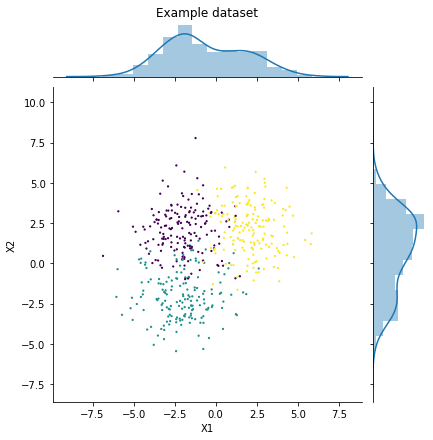

In [7]:
# example

g = seaborn.JointGrid(x="X1", y="X2", data=df)
g.plot_joint(plt.scatter, c=df["y"], s=1.5)
g.plot_marginals(seaborn.distplot)
_ = g.ax_marg_x.set_title("Example dataset")

## Comparison experiment

In [8]:
def fit_and_predict(args, clf, return_prob_matrix=False):
    """Fit a classifier on synthetic training data, and predict on synthetic testing data.

    Arguments:
        args {NameSpace} -- Arguments passed on the command line
        clf {scikit-learn model} -- Classifier to fit and evaluate (needs to have `predict_proba` method)

    Raises:
        ValueError: raised when classifier does not have `predict_proba` method

    Returns:
        tuple -- contains prediction probabilities on test set, predictions on test set, true test labels and true class probabilities
    """    
    
    # generate the data
    X, y, z = generate_data(samples, args.features, args.classes, args.std, args.radius, args.imbalance)

    # randomized train/test split
    X_train, X_test, y_train, y_test, z_train, z_test = sklearn.model_selection.train_test_split(X, y, z, test_size=0.2)

    # fit the classifier
    clf.fit(X_train, y_train)

    # compute predicted labels
    y_preds = clf.predict(X_test)

    # compute predicted probability vectors
    if hasattr(clf, 'predict_proba'):
        y_probs = clf.predict_proba(X_test)
        if not return_prob_matrix:
            y_probs = y_probs[:, y_preds][:, 0]
    else:
        raise ValueError(clf)

    return y_probs, y_preds, y_test, z_test

In [13]:
class args:
    features = 2
    std = 1.
    radius = 1.5
    imbalance = 1.
    classes = 3

y_probs, y_preds, y_test, z_test = fit_and_predict(args(), sklearn.ensemble.RandomForestClassifier(n_estimators=10), return_prob_matrix=True)

In [14]:
def true_ce(y_probs, z_probs):
    """Compute the true calibration error.

    Parameters:
    y_probs (np.array): predicted class probabilities
    z_probs (np.array): true class probabilities

    Returns:
    ce (float): true calibration error

    """

    # check inputs
    assert len(y_probs.shape) == 1 and y_probs.dtype in [np.float, np.float32], 'Predicted class probabilties should be an array of floats'
    assert all(y_probs >= 0) and all(y_probs <= 1), 'Predicted class probabilities should lie between 0 and 1'
    assert len(z_probs.shape) == 1 and z_probs.dtype in [np.float, np.float32] , 'True class probabilties should be an array of floats'
    assert all(z_probs >= 0) and all(z_probs <= 1), 'True class probabilities should lie between 0 and 1'

    # compute calibration error
    ce = abs(y_probs - z_probs).mean()
    return ce


def error_metrics(y_probs, y_preds, y_test, z_probs):
    
    y_probs_max = y_probs.max(axis=1)
    
    return {
        'true_ce': [true_ce(y_probs_max, z_probs)],
        'ece': [metrics.ece(y_probs_max, y_preds, y_test)],
        'ece_balanced': [metrics.ece(y_probs_max, y_preds, y_test, balanced=True)],
        'peace': [metrics.peace(y_probs_max, y_preds, y_test)],
        'class_wise_ece': [metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece)],
        'class_wise_ece_balanced': [metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, balanced=True)],
        'class_wise_peace': [metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace)],
    }

            
def compute_error_metrics(args, clf):
    """Fit classifier and compute ECE, ECEv2 and ECEv3 on predictions

    Arguments:
        args {NameSpace} -- Arguments passed on the command line
        clf {scikit-learn model} -- Classifier to fit and evaluate (needs to have `predict_proba` method)

    Returns:
        pandas.DataFrame -- Single-row Dataframe with one column per error metric
    """    

    y_probs, y_preds, y_test, z_test = fit_and_predict(args, clf, return_prob_matrix=True)
    
    # compute actual probability vectors
    z_probs = z_test[:, y_preds][:, 0]
    
    # store results
    return pd.DataFrame(error_metrics(y_probs, y_preds, y_test, z_probs))

In [15]:
# example
error_metrics(y_probs, y_preds, y_test, z_test[:, y_preds][:, 0])

{'true_ce': [0.41356740293434113],
 'ece': [0.1471],
 'ece_balanced': [0.14876610500905818],
 'peace': [0.1529122908364472],
 'class_wise_ece': [0.09873333333333338],
 'class_wise_ece_balanced': [0.14238584743100888],
 'class_wise_peace': [0.14658609190062669]}

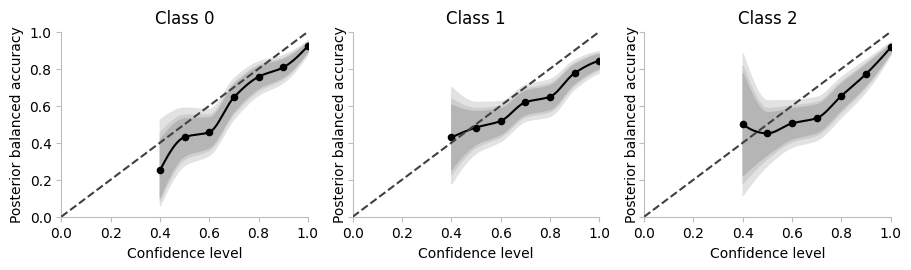

In [16]:
# example
from ridgereliability import plots
_ = plots.class_wise_posterior_reliability_diagram(y_probs, y_preds, y_test, bins=10)

In [51]:
def run_one_configuration(args, clfs=classifiers, output=None, save=True):
    """Run error metric experiment.

    Arguments:
        args {NameSpace} -- Arguments passed on the command line

    Keyword Arguments:
        output {str} -- path to file where output should be stored (default: {None})
    """

    logger = logging.getLogger(__name__)

    # make process pool
    with multiprocessing.Pool(processes=args.n_processes) as pool:

        # submit experiments to the pool
        promises = []
        for clf, name in clfs:
            # perform several runs
            for run in range(repeats):
                # run async operation
                promises.append((
                    name,
                    pool.apply_async(compute_error_metrics, (args, clf))
                ))

        # pull results from pool
        results = {k: [] for _, k in clfs}
        progbars = {
            k: trange(repeats, position=i, desc=k)
            for i, (_, k) in enumerate(clfs)
        }
        for name, promise in promises:
            # progress bar update
            try:
                results[name].append(promise.get())
            except Exception as e:
                logger.exception("Error in pool thread.")
            progbars[name].update(1)

        results = {k: pd.concat(v) for k, v in results.items() if len(v) > 0}

    # save results
    if save:
        if len(results) > 0:
            print('Saving...')
            filename = output or f'../results/run_{int(time.time())}_error_metrics.dat'
            with open(filename, 'wb') as log:
                pickle.dump(results, log)

In [52]:
def run_all_configurations(args, clfs=classifiers):
    """Run erorr metric experiment for each combination in the parameter grid. 

    Arguments:
        args {NameSpace} -- Arguments passed on the command line (ignores features, std, radius, imbalance and classes)
    """

    logger = logging.getLogger(__name__)
    
    # define grid
    parameter_grid = [i for i in dataset_config_grid]

    logger.info(f"Parameter grid size is {len(parameter_grid)}")

    if args.analysis is not None:

        # load previous analysis (= dataframe containing instances)
        analysis = load(args.analysis)

        # convert list of parameter combinations to dataframe
        parameter_grid = pd.DataFrame(parameter_grid)

        # check for each combination if results are present in the previous analysis
        parameter_grid["results?"] = parameter_grid.apply(lambda a: (analysis[a.index] == a).all(axis=1).any(), axis=1)
        
        # keep only those combinations for which no results are computed yet
        parameter_grid = parameter_grid[~parameter_grid["results?"]].to_dict('records')
        
        logger.info(f"After looking at existing analysis {len(parameter_grid)} parameter combinations remain")
    
    # select range of parameter combinations based on task index
    start_idx = (args.task_id-1)*(len(parameter_grid)//args.n_tasks)
    if args.task_id == args.n_tasks:
        end_idx = len(parameter_grid)
    else:
        end_idx = args.task_id*(len(parameter_grid)//args.n_tasks)

    # select subset of parameter combinations for this qsub tasks
    parameter_grid = [parameter_grid[i] for i in range(start_idx, end_idx)]

    logger.info(f"[{args.task_id}/{args.n_tasks}] run grid combinations {start_idx} to {end_idx}")

    # loop over all combinations
    runs = {}
    for instance, i in zip(parameter_grid, range(start_idx, end_idx)):

        # update the arguments with the current parameter combination
        vars(args).update(instance)

        filename = os.path.join(args.output_dir, f"{i}.dat")
        run_one_configuration(args, clfs, output=filename)

        # dump meta data (dump at every stap to have intermediate results)
        meta = vars(args).copy()
        meta["filename"] = os.path.basename(filename)
        for k, v in meta.items():
            runs.setdefault(k, []).append(v)

        with open(os.path.join(args.output_dir, f"runs_{start_idx}_{end_idx-1}.dat"), "wb") as pkl:
            pickle.dump(pd.DataFrame(runs), pkl)

# Command line

In [53]:
if __name__ == "__main__":
    import argparse
    import shutil
    logging.basicConfig(level=logging.DEBUG)
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--n-processes', type=int, default=16, help='number of processes to create in pool')
    parser.add_argument('--task-id', type=int, help='qsub TASK_ID', default=1)
    parser.add_argument('--n-tasks', type=int, help="amount of qsub tasks", default=1)
    parser.add_argument('--output-dir', type=str, help="directory to store grid results", required=True)
    parser.add_argument('--analysis', type=str, default=None, help="previous analysis")
    parser.add_argument('--remove', action="store_true", help="remove output dir if it exists")
    parser.add_argument('--dummy', action="store_true", help="use a dummy classifier")
    
    args = parser.parse_args()
    
    # create output dir if neccesary
    if "output_dir" in args:
        if os.path.exists(args.output_dir):
            if args.remove:
                shutil.rmtree(args.output_dir)
                os.mkdir(args.output_dir)
        else:
            os.mkdir(args.output_dir)
    
    if args.dummy:
        run_all_configurations(args, clfs=[(sklearn.ensemble.RandomForestClassifier(n_estimators=10), "dummy")])
    run_all_configurations(args)

usage: ipykernel_launcher.py [-h] [--n-processes N_PROCESSES] [--task-id TASK_ID] [--n-tasks N_TASKS] --output-dir OUTPUT_DIR [--analysis ANALYSIS]
                             [--remove] [--dummy]
ipykernel_launcher.py: error: the following arguments are required: --output-dir


SystemExit: 2

/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
